* Dropout as a Bayesian Approximation
* See, https://arxiv.org/abs/1506.02142

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
train, valid = chainer.datasets.get_mnist()

In [4]:
train_x, train_y = train._datasets
valid_x, valid_y = valid._datasets

train_x = train_x.reshape(len(train_x), 1, 28, 28).astype(np.float32)
train_y = train_y.astype(np.int32)
valid_x = valid_x.reshape(len(valid_x), 1, 28, 28).astype(np.float32)
valid_y = valid_y.astype(np.int32)

train_dataset = chainer.datasets.tuple_dataset.TupleDataset(train_x, train_y)
valid_dataset = chainer.datasets.tuple_dataset.TupleDataset(valid_x, valid_y)

len(train_dataset), len(valid_dataset)

(60000, 10000)

In [5]:
class Model(chainer.Chain):
    
    def __init__(self):
        
        super(Model, self).__init__()
        with self.init_scope():
            
            self.conv1 = L.Convolution2D(1, 16, 3)
            self.conv2 = L.Convolution2D(16, 32, 3)
            self.fc3 = L.Linear(None, 1000)
            self.fc4 = L.Linear(1000, 1000)
            self.fc5 = L.Linear(1000, 10)
            
    def __call__(self, x, extract_feature=False):
        
        h1 = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h2 = F.max_pooling_2d(F.relu(self.conv2(h1)), 2)
        h3 = F.dropout(F.relu(self.fc3(h2)))
        h4 = F.dropout(F.relu(self.fc4(h3)))
        y = self.fc5(h4)
        return y

In [6]:
gpu = 0

model = L.Classifier(Model())
optimizer = chainer.optimizers.Adam(alpha=1e-4)
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

In [7]:
epoch_num = 10
batch_size = 1000

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.33557     0.406201              0.599683       0.8953                    14.9652       
2           0.401305    0.206102              0.8787         0.939                     15.8036       
3           0.247192    0.148937              0.925967       0.9547                    16.643        
4           0.185261    0.112799              0.943833       0.9653                    17.4826       
5           0.147961    0.0904795             0.95635        0.9712                    18.3221       
6           0.122089    0.0776077             0.9631         0.9757                    19.1644       
7           0.106214    0.0661812             0.96845        0.9785                    20.007        
8           0.094281    0.0601856             0.971783       0.9807                    20.8508       
9           0.0852413   0.05379               0.974433       0.983                  

In [8]:
model.to_cpu()

In [9]:
def show(target_num):

    sampling_num = 50

    target_x = valid_x[np.where(valid_y == target_num)]

    entropy = np.zeros((len(target_x)), dtype=np.float32)

    for i in tqdm(range(len(target_x))):

        x = target_x[i]
        x = x[np.newaxis]
        preds = np.zeros((sampling_num, 10), dtype=np.float32)

        for j in range(sampling_num):

            with chainer.using_config('train', True):

                preds[j, :] = F.softmax(model.predictor(x), axis=1).data.squeeze()

        preds = preds.mean(axis=0)
        entropy[i] = np.sum(-preds*np.log(preds))

    target_imgs = target_x.reshape(len(target_x), 28, 28)
    target_imgs *= 255
    target_imgs = target_imgs.astype(np.uint8)

    high_entropy_imgs = target_imgs[np.argsort(entropy)[::-1][:30]]
    low_entropy_imgs = target_imgs[np.argsort(entropy)[:30]]

    fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 5))

    for i, img in enumerate(low_entropy_imgs):

        img = Image.fromarray(img)
        axs[i//10, i%10].imshow(img)
        axs[i//10, i%10].axis('off')

    plt.suptitle('low entropy top 30')
    plt.show()

    fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 5))

    for i, img in enumerate(high_entropy_imgs):

        img = Image.fromarray(img)
        axs[i//10, i%10].imshow(img)
        axs[i//10, i%10].axis('off')

    plt.suptitle('high entropy top 30')
    plt.show()

100%|██████████| 980/980 [02:46<00:00,  5.88it/s]


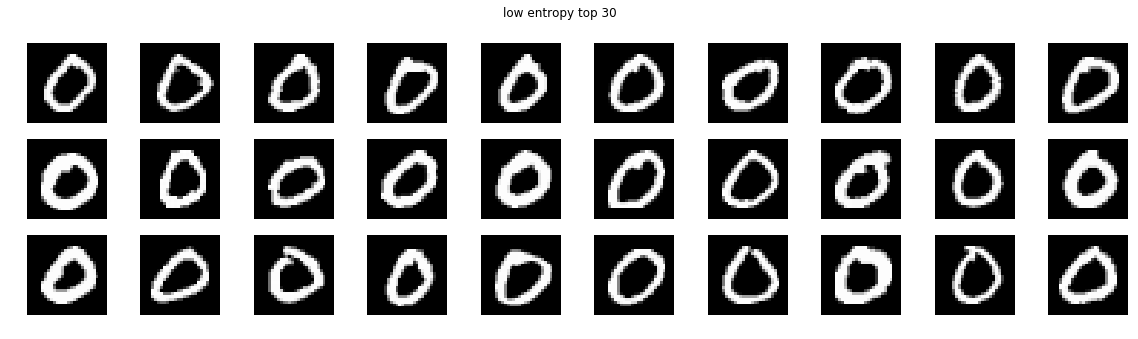

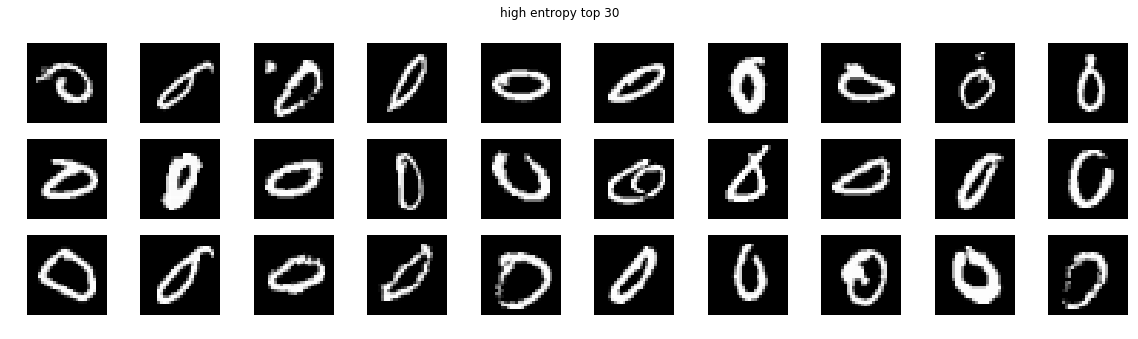

In [10]:
show(0)

100%|██████████| 1135/1135 [03:12<00:00,  5.90it/s]


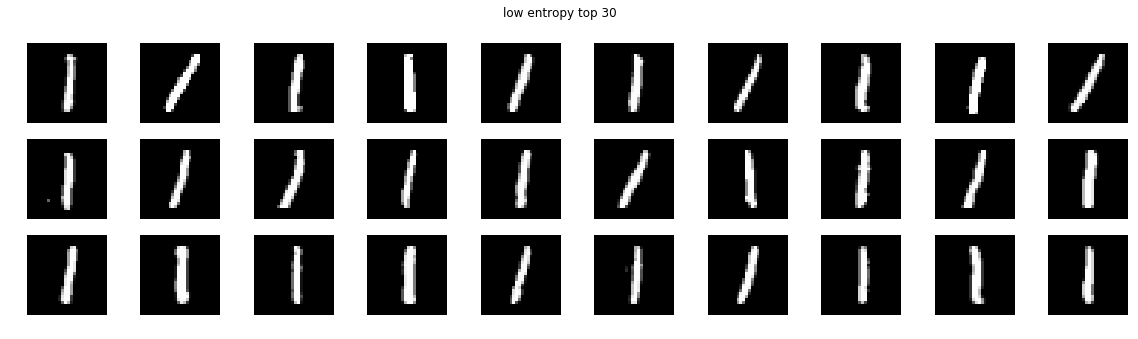

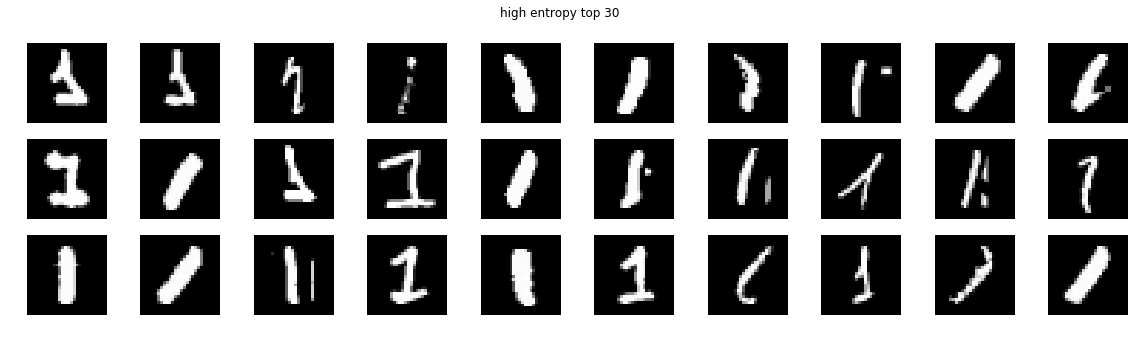

In [15]:
show(1)

100%|██████████| 1032/1032 [03:16<00:00,  5.25it/s]


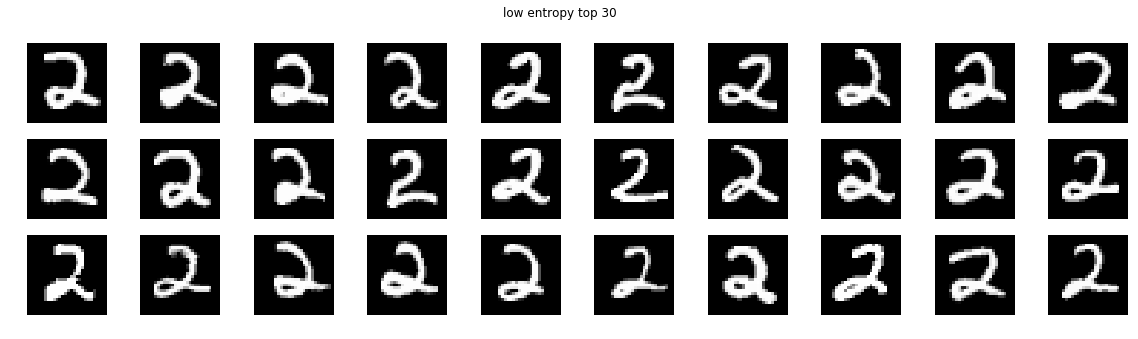

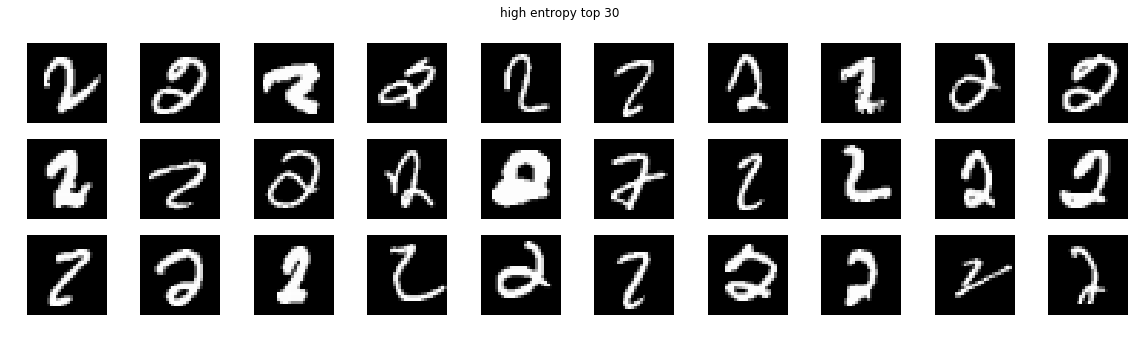

In [16]:
show(2)

100%|██████████| 1010/1010 [03:32<00:00,  4.76it/s]


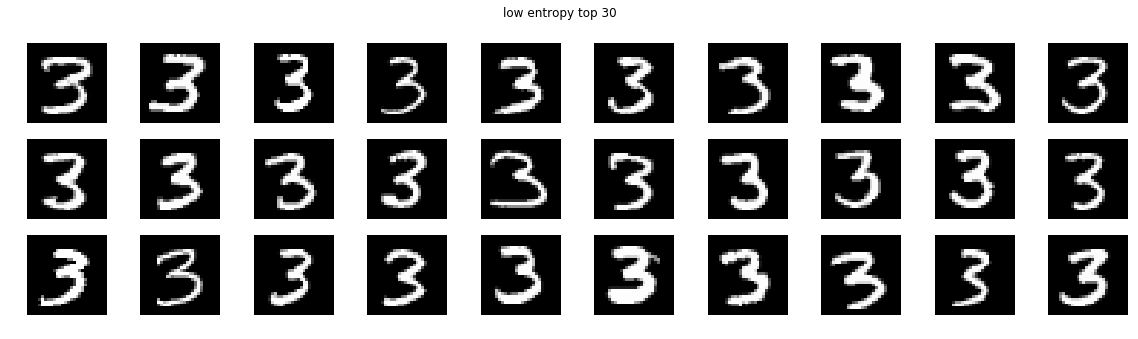

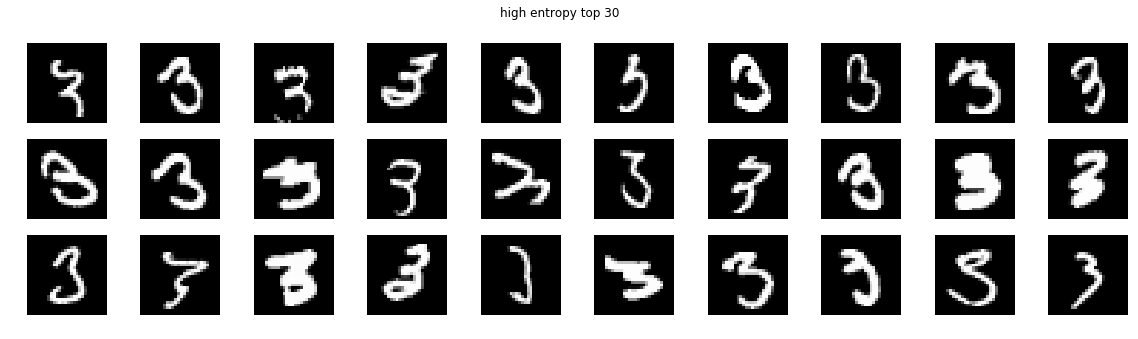

In [17]:
show(3)

100%|██████████| 982/982 [03:26<00:00,  4.76it/s]


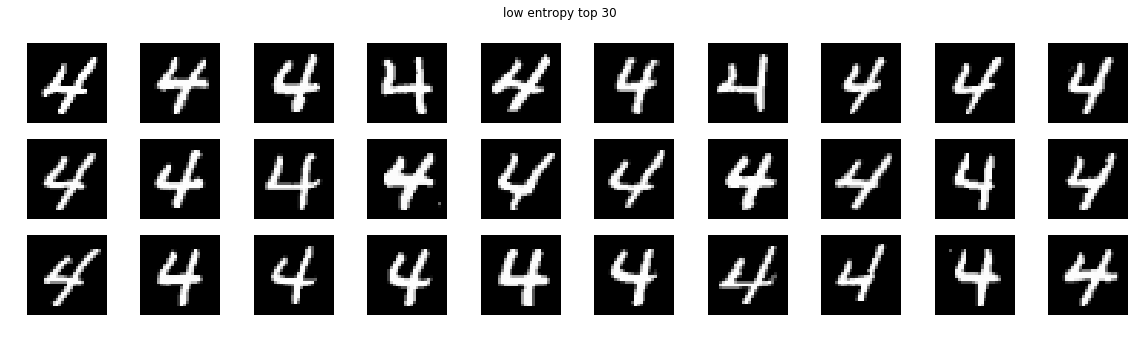

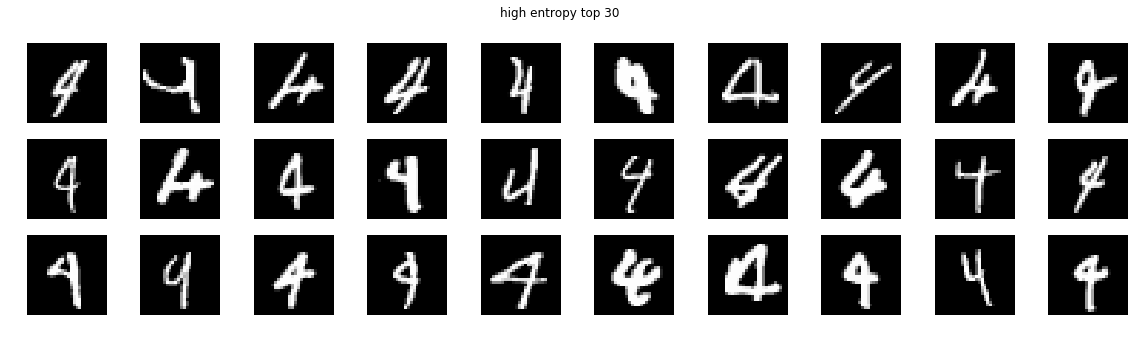

In [18]:
show(4)

100%|██████████| 892/892 [03:08<00:00,  4.74it/s]


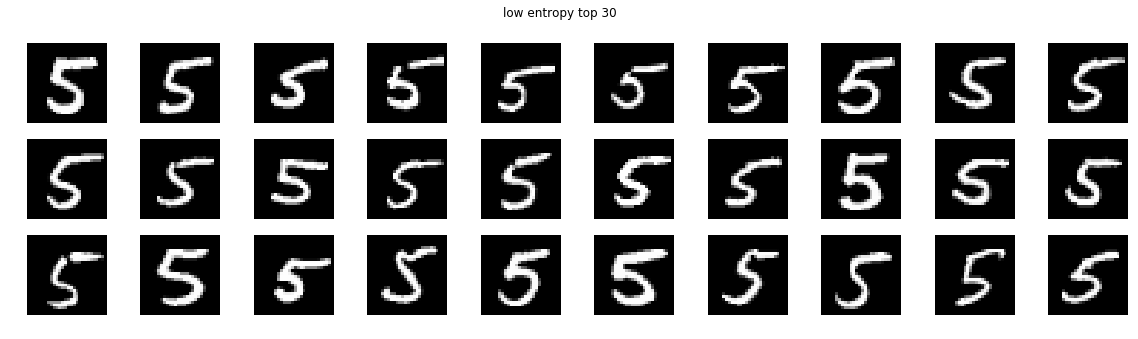

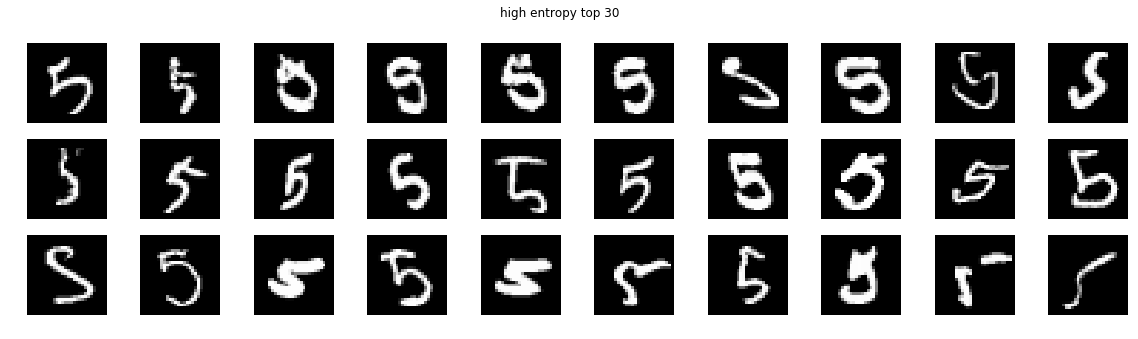

In [19]:
show(5)

100%|██████████| 958/958 [03:22<00:00,  4.72it/s]


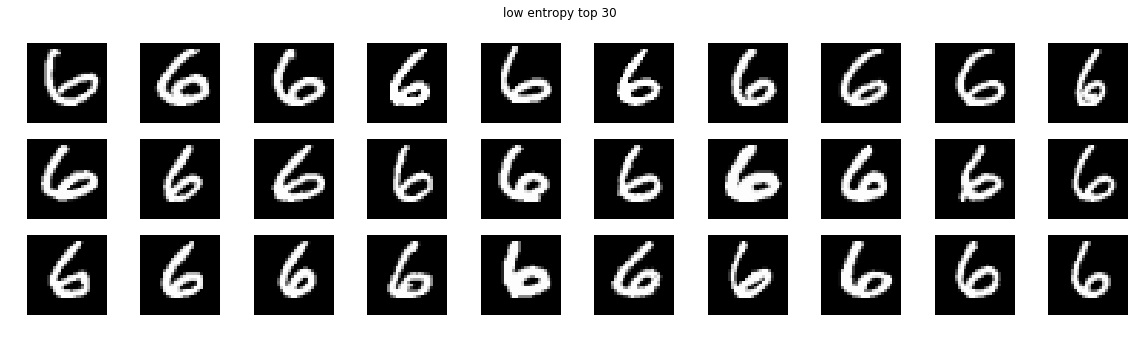

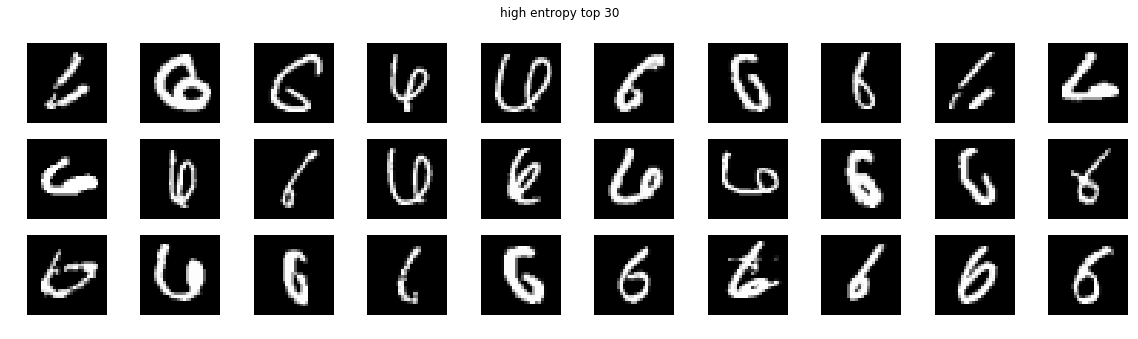

In [20]:
show(6)

100%|██████████| 1028/1028 [04:14<00:00,  4.04it/s]


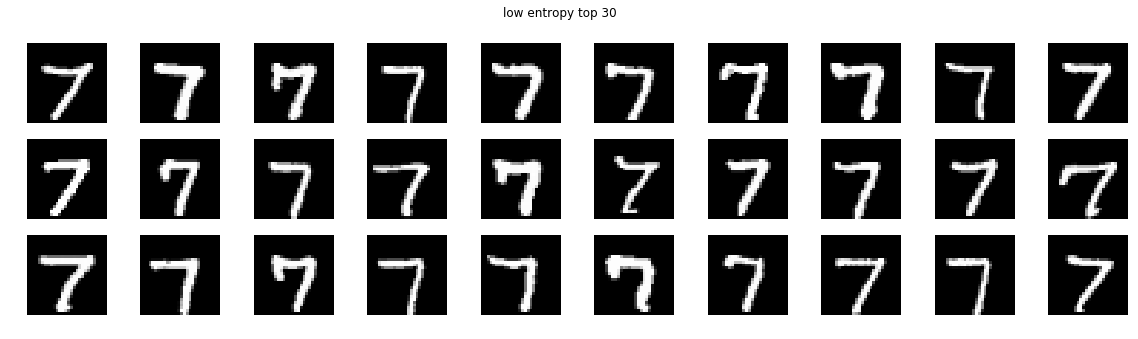

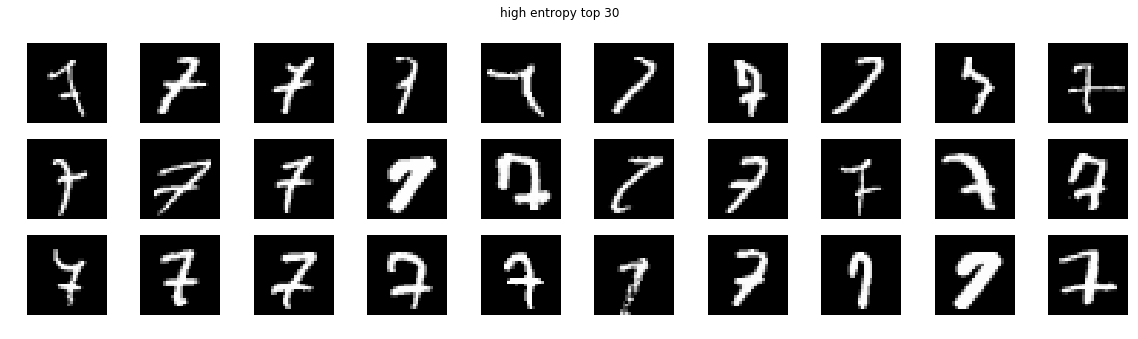

In [21]:
show(7)

100%|██████████| 974/974 [05:26<00:00,  2.98it/s]


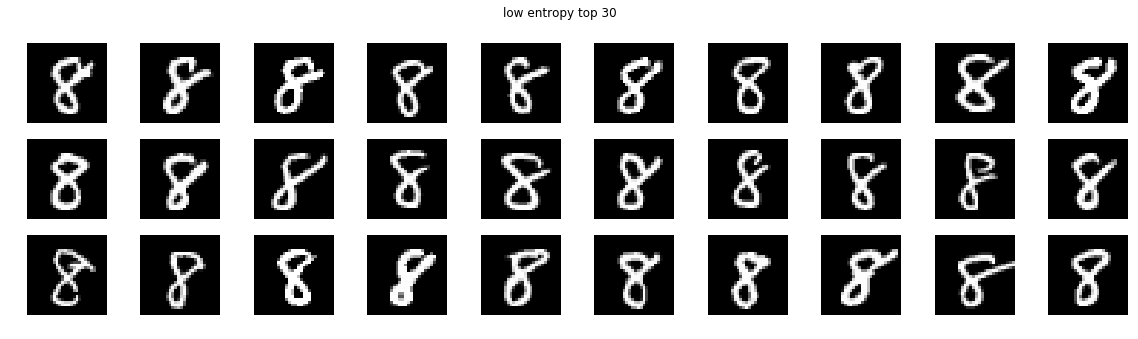

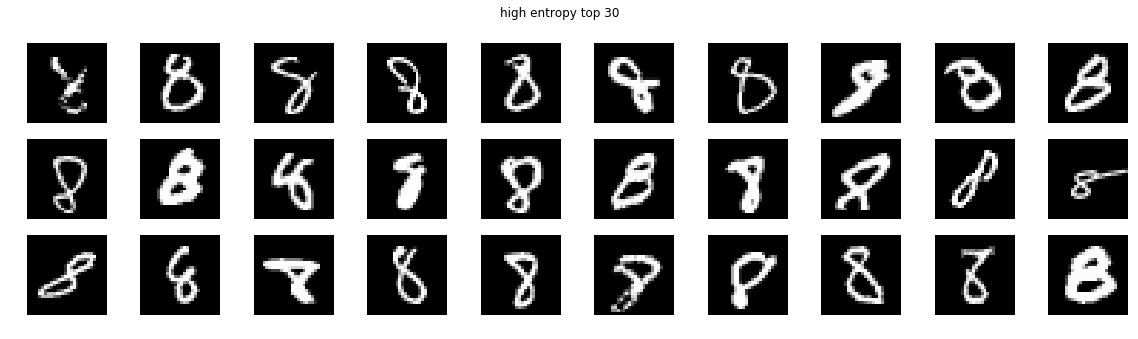

In [22]:
show(8)

100%|██████████| 1009/1009 [04:42<00:00,  3.57it/s]


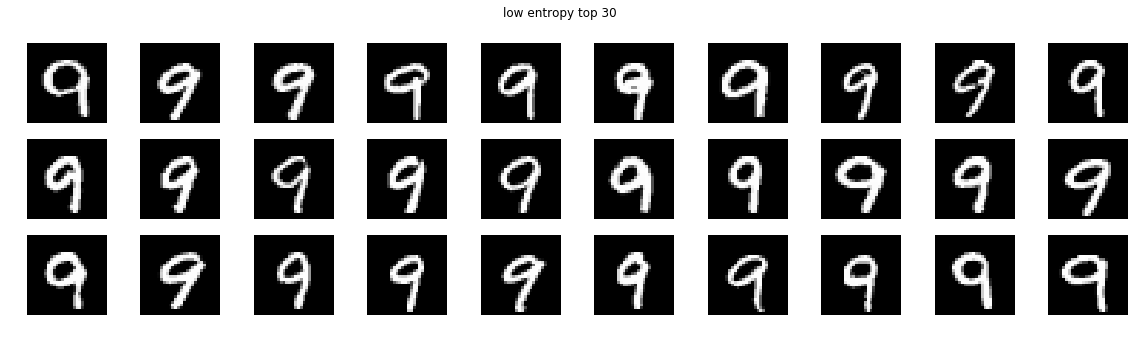

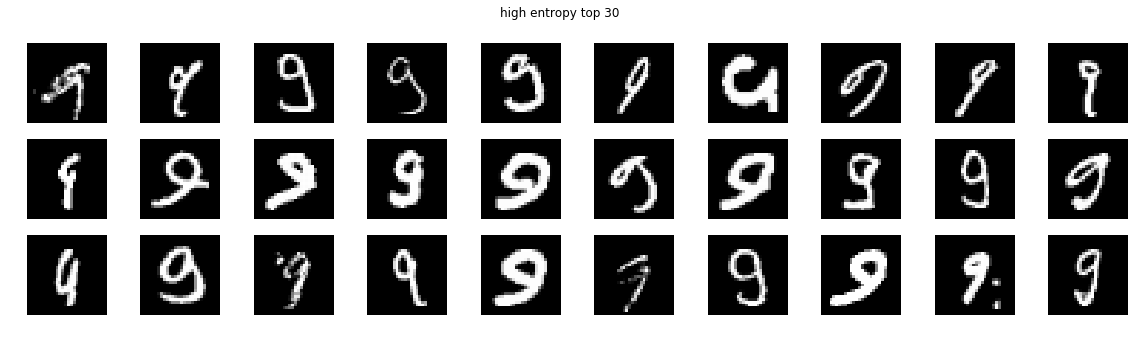

In [23]:
show(9)

In [11]:
!python --version

Python 3.6.3


In [12]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl=

In [13]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [14]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
